In [1]:
# Import packages and setup gpu configuration.
# This code block shouldnt need to be adjusted!
import os
import sys
import json
import yaml
import numpy as np
import math
import time
from datetime import datetime, timedelta
import random
from tqdm import tqdm
import webdataset as wds
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms
import utils
import h5py

from mae_utils import models
# from mae_utils.flat import NSDDataset, load_nsd_flat_mask, load_nsd_flat_mask_visual
from mae_utils.flat import HCPDataset, load_hcp_flat_mask
import mae_utils.visualize as vis
from mae_utils.logging import get_system_metrics

torch.backends.cuda.matmul.allow_tf32 = True # faster than standard float32
torch.backends.cudnn.allow_tf32 = True
torch.backends.cudnn.benchmark = True # fixes Conv3D CUDNN_NOT_SUPPORTED error

### Multi-GPU config ###
device_count = torch.cuda.device_count()
print(f"Number of available CUDA devices: {device_count}")

local_rank = os.getenv('LOCAL_RANK')
local_rank = 0 if local_rank is None else int(local_rank)
print(f"LOCAL RANK={local_rank}")

num_devices = os.getenv('NUM_GPUS')
num_devices = 1 if num_devices is None else int(num_devices)
print(f"NUM GPUS={num_devices}")
distributed = True if num_devices>1 else False
if distributed: assert device_count==num_devices

node = os.getenv('SLURM_NODEID')
node = 0 if node is None else int(node)
print(f"NODE={node}")

global_rank = os.getenv('RANK')
global_rank = 0 if global_rank is None else int(global_rank)
print(f"GLOBAL RANK={global_rank}")

world_size = os.getenv('WORLD_SIZE')
world_size = 1 if world_size is None else int(world_size)
print(f"WORLD_SIZE={world_size}")

if utils.is_interactive():
    # Following allows you to change functions in other files and 
    # have this notebook automatically update with your revisions
    get_ipython().run_line_magic('load_ext', 'autoreload')
    get_ipython().run_line_magic('autoreload', '2')

# Specify the model you will be fine-tuning from!
print("\n__LOADING CONFIG__")
model_name = os.getenv('model_name')
if model_name is None:
    model_name = "HCP_large__19553"
outdir = os.path.abspath(f'checkpoints/{model_name}')
print("outdir", outdir)
# Load the config.yaml associated with that ckpt
assert os.path.exists(f"{outdir}/config.yaml")
config = yaml.load(open(f"{outdir}/config.yaml", 'r'), Loader=yaml.FullLoader)
print(f"Loaded config.yaml from ckpt folder {outdir}")
# create global variables from the config
for attribute_name in config.keys():
    if global_rank==0:
        print(f"{attribute_name} = {config[attribute_name]}")
    globals()[attribute_name] = config[f'{attribute_name}']
print("\n")

# setup wandb seed
if wandb_log and (wandb_rand==0):
    wandb_rand = str(np.random.randint(99998)+1)
    print("wandb_rand", wandb_rand)
    model_name = model_name + "_" + str(wandb_rand)

data_type = torch.float32 # change depending on your mixed_precision
batch_size = os.getenv('batch_size')
batch_size = 8 if batch_size is None else int(batch_size)
global_batch_size = batch_size * world_size

model_name_suffix = os.getenv('model_name_suffix')
model_name_suffix = "" if model_name_suffix is None else (model_name_suffix+"_FT")

# FSDP Setup
if distributed:
    import torch.distributed as dist
    from torch.distributed.fsdp import FullyShardedDataParallel as FSDP
    from torch.distributed.fsdp import MixedPrecision, StateDictType
    from torch.distributed.fsdp.api import CPUOffload, ShardingStrategy
    import functools
    from torch.distributed.fsdp.wrap import size_based_auto_wrap_policy, transformer_auto_wrap_policy
    print(f"setting device to cuda:{local_rank}")
    torch.cuda.set_device(local_rank)
    device = torch.device('cuda',local_rank)
    os.environ['TORCH_NCCL_BLOCKING_WAIT'] = '0'
    dist.init_process_group("nccl", timeout=timedelta(seconds=720000), rank=global_rank, world_size=world_size)
    print(f"\nSuccessfully set cuda:{local_rank} | global_rank{global_rank} | node{node}")
    dist.barrier() 
    print(f"global_rank{global_rank} passed barrier")
else:
    device = torch.device('cuda')

print("PID of this process =",os.getpid())
print("device =", device, "distributed =",distributed, "num_devices =", num_devices, "local rank =", local_rank, "world size =", world_size, "data_type =", data_type)

# seed all random functions
utils.seed_everything(seed + global_rank)

Number of available CUDA devices: 4
LOCAL RANK=0
NUM GPUS=1
NODE=0
GLOBAL RANK=0
WORLD_SIZE=1

__LOADING CONFIG__
outdir /scratch/gpfs/ps6938/fMRI-foundation-model/src/checkpoints/HCP_large__19553
Loaded config.yaml from ckpt folder /scratch/gpfs/ps6938/fMRI-foundation-model/src/checkpoints/HCP_large__19553
base_lr = 0.001
batch_size = 32
ckpt_interval = 25
ckpt_saving = True
cls_embed = False
cls_forward = False
contrastive_loss_weight = 1.0
datasets_to_include = HCP
decoder_cls_embed = False
decoder_embed_dim = 512
global_pool = False
grad_accumulation_steps = 1
grad_clip = 1.0
gsr = False
hcp_flat_path = /scratch/gpfs/KNORMAN/HCP-Flat
mask_ratio = 0.75
model_name = HCP_large_
model_size = large
no_qkv_bias = False
norm_pix_loss = False
nsd_flat_path = /scratch/gpfs/KNORMAN/NSD-Flat
num_epochs = 100
num_frames = 16
num_samples_per_epoch = 200000
num_sessions = 40
num_workers = 1
patch_size = 16
pct_masks_to_decode = 1
plotting = True
pred_t_dim = 8
print_interval = 20
resume_from_ckp

In [2]:
num_samples_per_epoch = os.getenv('num_samples_per_epoch')
num_samples_per_epoch = 10000 if num_samples_per_epoch is None else int(num_samples_per_epoch)
print("num_samples_per_epoch", num_samples_per_epoch)

num_epochs = os.getenv('num_epochs')
num_epochs = 50 if num_epochs is None else int(num_epochs)
print("num_epochs", num_epochs)

INCLUDE_CONDS = [
    "fear", "neut", "math", "story", "lf", "lh", "rf", "rh", "t", "match", "relation",
    "mental", "rnd", "0bk_body", "2bk_body", "0bk_faces", "2bk_faces", "0bk_places",
    "2bk_places", "0bk_tools", "2bk_tools",
]

num_samples_per_epoch 10000
num_epochs 50


In [6]:
flat_mask = load_hcp_flat_mask(hcp_flat_path)
nsd_mask, hcp_mask = None, None

train_dataset = HCPDataset(root=hcp_flat_path,
                              split="train", # train=19464 (1096 subjects) test=2169 (919 subjects) all=21633
                              same_run_samples=1, 
                              frames=num_frames,
                              cond_subset=True)
train_dl = wds.WebLoader(train_dataset.get_dataset(), 
                             batch_size=batch_size,
                             num_workers=num_workers,
                             drop_last=True,
                             persistent_workers=True)
print(f"Number of unique training samples: {train_dataset.len_unique_samples}")

test_dataset = HCPDataset(root=hcp_flat_path,
                              split="test",
                              same_run_samples=1, 
                              frames=num_frames)
test_dl = wds.WebLoader(test_dataset.get_dataset(), 
                             batch_size=batch_size,
                             num_workers=num_workers,
                             drop_last=True,
                             persistent_workers=True)
num_test_batches = 2169 // batch_size
print("num_test_batches", num_test_batches)
print(f"Number of unique testing samples: {test_dataset.len_unique_samples}")

Number of unique training samples: 19464
num_test_batches 271
Number of unique testing samples: 2169


  0%|                                                                               | 0/10 [00:00<?, ?it/s]

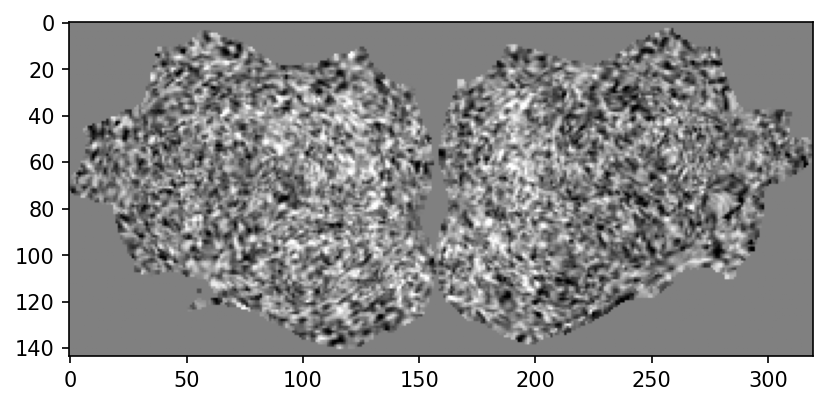

100%|██████████████████████████████████████████████████████████████████████| 10/10 [00:18<00:00,  1.86s/it]

input_func torch.Size([8, 1, 16, 144, 320])
Execution time: 18.710293769836426 seconds


In [7]:
if utils.is_interactive():    
    start_time = time.time() 
    num_iters = 10 # set maximum iterations the loop will go for
    data_iter = iter(train_dl)
    
    for i in tqdm(range(num_iters)):
        batch = next(data_iter)
        meta = batch[1]
        input_func = batch[0].view(-1, *batch[0].shape[2:])

        # for t in meta['task']:
        #     if "REST" in t:
        #         t = "REST"
        #     tasks.add(t)
            
        if len(input_func) != batch_size:
            raise ValueError(f"Input length ({len(input_func)}) does not match the expected batch size ({batch_size}).")

        if i==0:
            plt.imshow(input_func[0,0,0], cmap='gray')
            plt.show()
    
    print("input_func", input_func.shape)
    
    end_time = time.time()  
    execution_time = end_time - start_time  
    print(f"Execution time: {execution_time} seconds")

### Creating and loading Model

In [7]:
assert model_size in {"huge", "large", "small"}, "undefined model_size"

if model_size=="huge":
    model = models.mae_vit_huge_fmri(
        patch_size=patch_size,
        decoder_embed_dim=decoder_embed_dim,
        t_patch_size=t_patch_size,
        pred_t_dim=pred_t_dim,
        decoder_depth=4,
        cls_embed=cls_embed,
        decoder_cls_embed=decoder_cls_embed,
        norm_pix_loss=norm_pix_loss,
        no_qkv_bias=no_qkv_bias,
        sep_pos_embed=sep_pos_embed,
        trunc_init=trunc_init,
        pct_masks_to_decode=pct_masks_to_decode,
        img_mask=flat_mask,
        use_source_embeds=use_source_embeds,
        use_contrastive_loss=use_contrastive_loss,
        use_decoder_contrastive_loss=use_decoder_contrastive_loss,
        source_embed_train_mode=source_embed_train_mode,
        source_embed_mode=source_embed_mode,
    )
elif model_size=="large":
    model = models.mae_vit_large_fmri(
        patch_size=patch_size,
        decoder_embed_dim=decoder_embed_dim,
        t_patch_size=t_patch_size,
        pred_t_dim=pred_t_dim,
        decoder_depth=4,
        cls_embed=cls_embed,
        decoder_cls_embed=decoder_cls_embed,
        norm_pix_loss=norm_pix_loss,
        no_qkv_bias=no_qkv_bias,
        sep_pos_embed=sep_pos_embed,
        trunc_init=trunc_init,
        pct_masks_to_decode=pct_masks_to_decode,
        img_mask=flat_mask,
        use_source_embeds=use_source_embeds,
        use_contrastive_loss=use_contrastive_loss,
        use_decoder_contrastive_loss=use_decoder_contrastive_loss,
        source_embed_train_mode=source_embed_train_mode,
        source_embed_mode=source_embed_mode,
    )
elif model_size=="small":
    model = models.mae_vit_small_fmri(
        patch_size=patch_size,
        decoder_embed_dim=decoder_embed_dim,
        t_patch_size=t_patch_size,
        pred_t_dim=pred_t_dim,
        decoder_depth=4,
        cls_embed=cls_embed,
        decoder_cls_embed=decoder_cls_embed,
        norm_pix_loss=norm_pix_loss,
        no_qkv_bias=no_qkv_bias,
        sep_pos_embed=sep_pos_embed,
        trunc_init=trunc_init,
        pct_masks_to_decode=pct_masks_to_decode,
        img_mask=flat_mask,
        use_source_embeds=use_source_embeds,
        use_contrastive_loss=use_contrastive_loss,
        use_decoder_contrastive_loss=use_decoder_contrastive_loss,
        source_embed_train_mode=source_embed_train_mode,
        source_embed_mode=source_embed_mode,
    )
utils.count_params(model)

img_size (144, 320) patch_size (16, 16) frames 16 t_patch_size 2
model initialized


In [8]:
try:
    checkpoint_files = [f for f in os.listdir(outdir) if f.endswith('.pth')]
    
    latest_checkpoint = "epoch199.pth"
    checkpoint_path = os.path.join(outdir, latest_checkpoint)
    if not os.path.exists(checkpoint_path):
        latest_checkpoint = "epoch99.pth"
        checkpoint_path = os.path.join(outdir, latest_checkpoint)
    print(f"latest_checkpoint: {checkpoint_path}")
    
    state = torch.load(checkpoint_path)
    model.load_state_dict(state["model_state_dict"], strict=False)
    
    print(f"\nLoaded checkpoint {latest_checkpoint} from {outdir}\n")
except:
    print("===\nNOT LOADING ANY PRETRAINED MODEL\n===")

latest_checkpoint: epoch99.pth


/tmp/ipykernel_1087257/781257473.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(checkpoint_path)



Loaded checkpoint epoch99.pth from /weka/proj-fmri/ckadirt/fMRI-foundation-model/src/checkpoints/HCPflat_large_gsrFalse_



In [9]:
class LinearClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(LinearClassifier, self).__init__()
        self.linear = nn.Linear(input_dim, num_classes)
        
    def forward(self, x):
        # Flatten the input except for the batch dimension
        x = x.view(x.size(0), -1)
        out = self.linear(x)
        return out  # Raw logits

# Determine the input dimension from a single sample
# Assuming images are of shape [1, 16, 144, 320]
input_dim = np.prod(mae_model(torch.randn(1,1,16,144,320).to(device),global_pool=global_pool, forward_features = True).shape[1:])
print(f"Input dimension: {input_dim}")

Input dimension: 1024


### Data

In [16]:
import uuid

myuuid = uuid.uuid4()
str(myuuid)

'9f9d4444-58f9-4378-9a9a-ea56bf707eb6'

In [17]:
import wandb

if utils.is_interactive():
    print("Running in interactive notebook. Disabling W&B and ckpt saving.")
    wandb_log = True
    save_ckpt = True

if wandb_log:
    wandb_project = 'fMRI-foundation-model'
    wandb_config = {
        "model_name": model_name+'_HCP_FT',
        "batch_size": batch_size,
        "learning_rate": learning_rate,
        "weight_decay": weight_decay,
        "num_epochs": num_epochs,
        "seed": seed,
    }
    print("wandb_config:\n", wandb_config)
    random_id = str(uuid.uuid4())
    print("wandb_id:", "HCPflat_raw" + f"_{random_id}")
    wandb.init(
        id=model_name+'_HCP_FT' + f"_{random_id}",
        project=wandb_project,
        name=model_name+'_HCP_FT',
        config=wandb_config,
        resume="allow",
    )

Running in interactive notebook. Disabling W&B and ckpt saving.
wandb_config:
 {'model_name': 'HCPflat_large_gsrFalse__HCP_FT', 'batch_size': 8, 'learning_rate': 0.0001, 'weight_decay': 1e-05, 'num_epochs': 20, 'seed': 42}
wandb_id: HCPflat_raw_7ee35929-85c0-47da-91ab-dac2776c444f


epoch_train_loss,█▄▁
epoch_val_loss,▂▁█
train_accuracy,▁▅█
val_accuracy,█▁▁
epoch_train_loss,1.35031
epoch_val_loss,3.83135
train_accuracy,59.09091
val_accuracy,25


In [ ]:
for epoch in range(num_epochs):
    running_train_loss = 0.0
    correct_train = 0
    total_train = 0
    step = 0

    # with torch.amp.autocast(device_type='cuda'):
    # Training Phase
    model.train()
    for  batch in tqdm(train_dl, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        optimizer.zero_grad()
        images = batch[0].to(device).float().unsqueeze(1) #fix this  # Shape: [batch_size, 1, 16, 144, 320]
        labels = batch[1]['trial_type']  # List of labels
        
        encoded_labels = label_encoder.transform(labels)
        encoded_labels = torch.tensor(encoded_labels, dtype=torch.long).to(device)  # Shape: [batch_size]
        
        # Forward pass
        outputs = model(images, gsr=gsr)  # Shape: [num_train_samples, num_classes]
        
        # Compute loss
        loss = criterion(outputs, encoded_labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Accumulate loss
        running_train_loss += loss.item() * images.size(0)

        
        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        
        correct_train += (predicted == encoded_labels).sum().item()
        total_train += encoded_labels.size(0)
        
        step = step + 1
        if step % 100 == 0:
            print(f"Step [{step}/{len(train_dl)}] - Training Loss: {loss.item():.4f} - Training Accuracy: {100 * correct_train / total_train:.2f}%")
        # thth

    epoch_train_loss = running_train_loss / total_train if total_train > 0 else 0.0
    train_accuracy = 100 * correct_train / total_train if total_train > 0 else 0.0
    
    # Validation Phase
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for batch in tqdm(test_dl, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            
            images = batch[0].to(device).float().unsqueeze(1) #fix this
            labels = batch[1]['trial_type']
            
            # Encode labels to integer indices
            encoded_labels = label_encoder.transform(labels)
            encoded_labels = torch.tensor(encoded_labels, dtype=torch.long).to(device)
            
        
            # Forward pass
            outputs = model(images, gsr=gsr)
            
            # Compute loss
            loss = criterion(outputs, encoded_labels)
            
            # Accumulate loss
            running_val_loss += loss.item() * images.size(0)
            
            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == encoded_labels).sum().item()
            total_val += encoded_labels.size(0)

            
    
    epoch_val_loss = running_val_loss / total_val if total_val > 0 else 0.0
    val_accuracy = 100 * correct_val / total_val if total_val > 0 else 0.0
    
    print(f"Epoch [{epoch+1}/{num_epochs}] "
        f"- Training Loss: {epoch_train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}% "
        f"- Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
    
    if wandb_log:
        wandb.log({
            "epoch_train_loss": epoch_train_loss,
            "epoch_val_loss": epoch_val_loss,
            "train_accuracy": train_accuracy,
            "val_accuracy": val_accuracy,
        })
    if save_ckpt:
        outdir = os.path.abspath(f'checkpoints/{model_name+"HCP_FT"}')
        os.makedirs(outdir, exist_ok=True)
        print("outdir", outdir)
        # Save model and config
        torch.save(model.state_dict(), f"{outdir}/model.pth")
        with open(f"{outdir}/config.yaml", 'w') as f:
            yaml.dump(wandb_config, f)
        print(f"Saved model and config to {outdir}")
    